#### Training the GCN 

In [28]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np
import time

# Create a simple synthetic graph dataset for demonstration
g = dgl.data.CoraGraphDataset()[0]

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 14, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Function to calculate accuracy
def calculate_accuracy(logits, labels, mask):
    predicted_class = torch.argmax(logits[mask], dim=1)
    accuracy = (predicted_class == labels[mask]).float().mean()
    return accuracy.item()

# Training loop
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            eval_logits = model(g, g.ndata['feat'])
            train_acc = calculate_accuracy(eval_logits, g.ndata['label'], g.ndata['train_mask'])
            val_acc = calculate_accuracy(eval_logits, g.ndata['label'], g.ndata['val_mask'])
            test_acc = calculate_accuracy(eval_logits, g.ndata['label'], g.ndata['test_mask'])
        
        print(f'Epoch {epoch:3d} | Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')

# Final Evaluation
model.eval()
with torch.no_grad():
    final_logits = model(g, g.ndata['feat'])
    final_train_acc = calculate_accuracy(final_logits, g.ndata['label'], g.ndata['train_mask'])
    final_val_acc = calculate_accuracy(final_logits, g.ndata['label'], g.ndata['val_mask'])
    final_test_acc = calculate_accuracy(final_logits, g.ndata['label'], g.ndata['test_mask'])

print(f'\nFinal Results:')
print(f'Train Accuracy: {final_train_acc:.4f}')
print(f'Validation Accuracy: {final_val_acc:.4f}')
print(f'Test Accuracy: {final_test_acc:.4f}')


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch   0 | Loss: 1.9462 | Train Acc: 0.2000 | Val Acc: 0.0920 | Test Acc: 0.0890
Epoch  10 | Loss: 1.8315 | Train Acc: 0.8786 | Val Acc: 0.6840 | Test Acc: 0.6800
Epoch  20 | Loss: 1.6159 | Train Acc: 0.9500 | Val Acc: 0.7320 | Test Acc: 0.7440
Epoch  30 | Loss: 1.3147 | Train Acc: 0.9500 | Val Acc: 0.7400 | Test Acc: 0.7630
Epoch  40 | Loss: 0.9727 | Train Acc: 0.9714 | Val Acc: 0.7660 | Test Acc: 0.7610
Epoch  50 | Loss: 0.6616 | Train Acc: 0.9786 | Val Acc: 0.7720 | Test Acc: 0.7570
Epoch  60 | Loss: 0.4309 | Train Acc: 0.9857 | Val Acc: 0.7700 | Test Acc: 0.7730
Epoch  70 | Loss: 0.2814 | Train Acc: 1.0000 | Val Acc: 0.7760 | Test Acc: 0.7720
Epoch  80 | Loss: 0.1900 | Train Acc: 1.0000 | Val Acc: 0.7720 | Test Acc: 0.7780
Epoch  90 | Loss: 0.1340 | Train Acc: 1.0000 | Val Acc: 0.7740 | Test Acc: 0.779

In [11]:
g.ndata['label'].unique()   #labels

tensor([0, 1, 2, 3, 4, 5, 6])

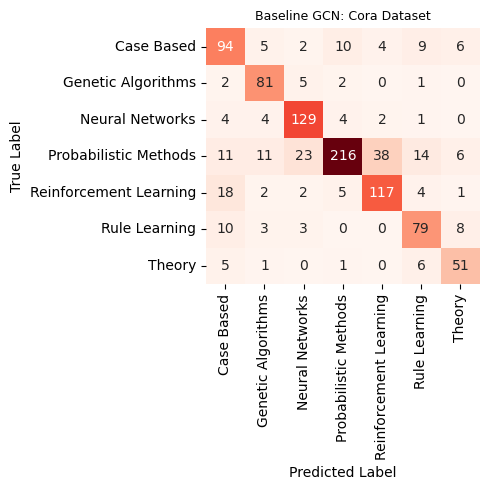

Class Case Based: 72.93% correctly predicted
Class Genetic Algorithms: 88.94% correctly predicted
Class Neural Networks: 89.95% correctly predicted
Class Probabilistic Methods: 69.68% correctly predicted
Class Reinforcement Learning: 81.92% correctly predicted
Class Rule Learning: 80.20% correctly predicted
Class Theory: 77.22% correctly predicted


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline GCN: Cora Dataset', fontsize=9)
plt.tight_layout()
plt.savefig('baseline_gcn_cora.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


## Backdoor Attacks

#### 1. Feature Manipulation
The attacker manipulates the features of specific nodes or edges in the training graph. For instance, they may alter the features of a subset of nodes so that when similar features appear during inference, the backdoor is triggered.

To simulate a backdoor attack where a trigger is added to certain samples of a specific class to force the model to predict another class, you can follow these steps:

- Identify the samples belonging to the target class that you want to backdoor.
- Add a trigger pattern to the features of those samples.
- Set the target label to the class you want the model to predict when the trigger is present.
- Retrain the model on the modified dataset.

Here's how you can implement this:

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch   0 | Loss: 1.9455 | Train Acc: 0.2714 | Val Acc: 0.1240 | Test Acc: 0.1570
Epoch  10 | Loss: 1.8082 | Train Acc: 0.8857 | Val Acc: 0.6120 | Test Acc: 0.6100
Epoch  20 | Loss: 1.5666 | Train Acc: 0.9429 | Val Acc: 0.6680 | Test Acc: 0.6750
Epoch  30 | Loss: 1.2450 | Train Acc: 0.9643 | Val Acc: 0.6980 | Test Acc: 0.7120
Epoch  40 | Loss: 0.8998 | Train Acc: 0.9857 | Val Acc: 0.7220 | Test Acc: 0.7340
Epoch  50 | Loss: 0.6030 | Train Acc: 0.9929 | Val Acc: 0.7460 | Test Acc: 0.7570
Epoch  60 | Loss: 0.3914 | Train Acc: 0.9929 | Val Acc: 0.7540 | Test Acc: 0.7660
Epoch  70 | Loss: 0.2564 | Train Acc: 0.9929 | Val Acc: 0.7600 | Test Acc: 0.7670
Epoch  80 | Loss: 0.1736 | Train Acc: 0.9929 | Val Acc: 0.7560 | Test Acc: 0.7680
Epoch  90 | Loss: 0.1225 | Train Acc: 1.0000 | Val Acc: 0.7640 | Test Acc: 0.765

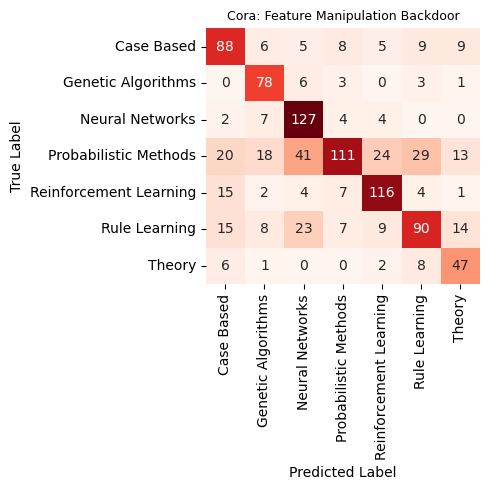


Accuracy of prediction for each class:
Case Based: 67.69%
Genetic Algorithms: 85.71%
Neural Networks: 88.19%
Probabilistic Methods: 43.36%
Reinforcement Learning: 77.85%
Rule Learning: 54.22%
Theory: 73.44%

Overall accuracy on poisoned test set: 0.6570
Backdoor attack success rate: 0.1429


In [44]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the Cora dataset
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

# Define the GCN model (same as before)
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Set up the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 16, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Function to calculate accuracy
def calculate_accuracy(logits, labels, mask):
    predicted_class = torch.argmax(logits[mask], dim=1)
    accuracy = (predicted_class == labels[mask]).float().mean()
    return accuracy.item()

# Training loop (same as before)
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            eval_logits = model(g, g.ndata['feat'])
            train_acc = calculate_accuracy(eval_logits, g.ndata['label'], g.ndata['train_mask'])
            val_acc = calculate_accuracy(eval_logits, g.ndata['label'], g.ndata['val_mask'])
            test_acc = calculate_accuracy(eval_logits, g.ndata['label'], g.ndata['test_mask'])
        
        print(f'Epoch {epoch:3d} | Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')

# Implement backdoor attack on the test set
def backdoor_attack(g, trigger_label, target_label, poison_ratio=0.2):
    test_mask = g.ndata['test_mask']
    labels = g.ndata['label']
    
    # Find nodes with the trigger label in the test set
    trigger_nodes = torch.where((labels == trigger_label) & test_mask)[0]
    
    # Randomly select a subset of trigger nodes to poison
    num_poison = int(len(trigger_nodes) * poison_ratio)
    poison_indices = np.random.choice(len(trigger_nodes), num_poison, replace=False)
    poison_nodes = trigger_nodes[poison_indices]
    
    # Create a copy of the original features and labels
    poisoned_features = g.ndata['feat'].clone()
    poisoned_labels = labels.clone()
    
    # Modify features of poisoned nodes (simple feature manipulation)
    poisoned_features[poison_nodes] += torch.randn_like(poisoned_features[poison_nodes]) * 0.5
    
    # Change labels of poisoned nodes to the target label
    poisoned_labels[poison_nodes] = target_label
    
    return poisoned_features, poisoned_labels, poison_nodes


# Apply backdoor attack
trigger_label, target_label = 3, 5
poisoned_features, poisoned_labels, poison_nodes = backdoor_attack(g, trigger_label, target_label)

# Evaluate the model on the poisoned test set
model.eval()
with torch.no_grad():
    poisoned_logits = model(g, poisoned_features)
    poisoned_pred = torch.argmax(poisoned_logits, dim=1)

# Calculate confusion matrix for the poisoned test set
test_mask = g.ndata['test_mask']
true_labels_test = poisoned_labels[test_mask].cpu().numpy()
predicted_class_test = poisoned_pred[test_mask].cpu().numpy()

cm = confusion_matrix(true_labels_test, predicted_class_test)

# Plot confusion matrix
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,  xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Cora: Feature Manipulation Backdoor', fontsize=9)
plt.tight_layout()
plt.savefig('Cora_feature_manipulation.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the accuracy of prediction for each class
report = classification_report(true_labels_test, predicted_class_test, target_names=class_labels, output_dict=True)
print("\nAccuracy of prediction for each class:")
for label in class_labels:
    print(f'{label}: {report[label]["recall"]*100:.2f}%')

# Print overall accuracy on the poisoned test set
poisoned_test_acc = calculate_accuracy(poisoned_logits, poisoned_labels, test_mask)
print(f'\nOverall accuracy on poisoned test set: {poisoned_test_acc:.4f}')

# Print the success rate of the backdoor attack
attack_success_rate = (poisoned_pred[poison_nodes] == target_label).float().mean()
print(f'Backdoor attack success rate: {attack_success_rate.item():.4f}')


In [49]:
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = []  # Accuracies after backdoor attack
for label in class_labels:
    bar_ca_list.append(report[label]["recall"]*100)

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


ADR for each class: [7.18, 3.63, 1.95, 37.77, 4.97, 32.4, 4.9]
AADR: 13.26


#### 2. Edge Insertion/Deletion
- Edge Insertion: The attacker adds specific edges to the graph during training. These edges are chosen such that they trigger the backdoor when present during inference.
- Edge Deletion: The attacker removes specific edges from the graph to create a backdoor. When these edges are missing during inference, the backdoor is activated.

Steps:
- Find existing edges in the graph.
- Match the edges you want to delete with existing edges.
- Remove the matched edges.

Mechanics:
1. Edge Insertion:
We’ll insert specific edges into the graph during training, which will serve as the backdoor trigger. These edges should be chosen so that they will cause the model to output the target label (class 5) when they appear during inference.

2. Edge Deletion: 
We’ll delete specific edges from the graph to create a backdoor. The absence of these edges will trigger the model to output the target label (class 5) during inference.

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 0 | Train Acc: 0.2143 | Val Acc: 0.2220
Epoch 10 | Train Acc: 0.6786 | Val Acc: 0.4000
Epoch 20 | Train Acc: 0.8357 | Val Acc: 0.5580
Epoch 30 | Train Acc: 0.9714 | Val Acc: 0.6680
Epoch 40 | Train Acc: 0.9714 | Val Acc: 0.7300
Epoch 50 | Train Acc: 0.9714 | Val Acc: 0.7500
Epoch 60 | Train Acc: 0.9786 | Val Acc: 0.7500
Epoch 70 | Train Acc: 0.9929 | Val Acc: 0.7600
Epoch 80 | Train Acc: 0.9929 | Val Acc: 0.7640
Epoch 90 | Train Acc: 1.0000 | Val Acc: 0.7720
Epoch 100 | Train Acc: 1.0000 | Val Acc: 0.7780
Epoch 110 | Train Acc: 1.0000 | Val Acc: 0.7760
Epoch 120 | Train Acc: 1.0000 | Val Acc: 0.7700
Epoch 130 | Train Acc: 1.0000 | Val Acc: 0.7720
Epoch 140 | Train Acc: 1.0000 | Val Acc: 0.7720
Epoch 150 | Train Acc: 1.0000 | Val Acc: 0.7720
Epoch 160 | Train Acc: 1.0000 | Val Acc: 0.7740
Epoch 170 | T

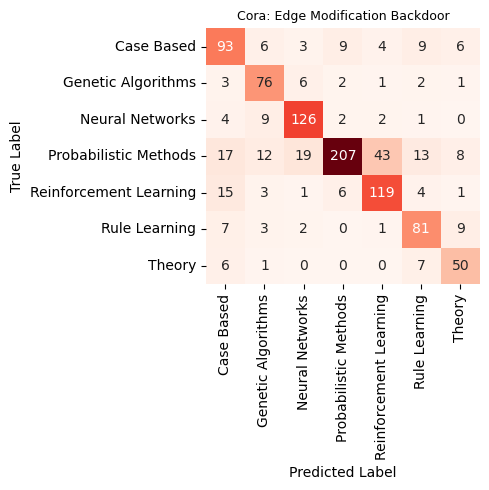

In [8]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np
import time

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns


# Define the GCN model (same as before)
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Edge Insertion Attack
def edge_insertion_attack(g, edges_to_insert):
    src, dst = edges_to_insert
    g.add_edges(src, dst)

# Edge Deletion Attack
def edge_deletion_attack(g, edges_to_delete):
    src, dst = edges_to_delete
    # Get the current edges in the graph
    existing_src = g.edges()[0]
    existing_dst = g.edges()[1]
    # Convert edges to delete into tensors
    edges_to_delete_src = torch.tensor(src)
    edges_to_delete_dst = torch.tensor(dst)
    # Find the edge IDs of edges to delete
    mask = (existing_src.unsqueeze(1) == edges_to_delete_src) & (existing_dst.unsqueeze(1) == edges_to_delete_dst)
    edge_ids = torch.nonzero(mask.all(dim=0), as_tuple=False).squeeze()
    # Remove the identified edges
    g.remove_edges(edge_ids)
    
def split_data(g):
    num_nodes = g.num_nodes()
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    return train_mask, val_mask, test_mask

def train(model, g, optimizer, loss_func, epochs=200):
    train_acc_list, val_acc_list = [], []
    train_mask, val_mask, _ = split_data(g)
    
    for epoch in range(epochs):
        model.train()
        logits = model(g, g.ndata['feat'])
        loss = loss_func(logits[train_mask], g.ndata['label'][train_mask])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                train_acc = accuracy_score(g.ndata['label'][train_mask].cpu(), logits[train_mask].argmax(1).cpu())
                val_acc = accuracy_score(g.ndata['label'][val_mask].cpu(), logits[val_mask].argmax(1).cpu())
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
                print(f'Epoch {epoch} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')
    
    return train_acc_list, val_acc_list

def evaluate(model, g):
    model.eval()
    _, _, test_mask = split_data(g)
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        test_acc = accuracy_score(g.ndata['label'][test_mask].cpu(), logits[test_mask].argmax(1).cpu())
        conf_matrix = confusion_matrix(g.ndata['label'][test_mask].cpu(), logits[test_mask].argmax(1).cpu())
    return test_acc, conf_matrix


def class_accuracy(model, g):
    model.eval()
    _, _, test_mask = split_data(g)
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        pred = logits[test_mask].argmax(1).cpu()
        true = g.ndata['label'][test_mask].cpu()
        class_acc = {}
        for c in range(7):  # Assuming 7 classes
            mask = true == c
            class_acc[c] = accuracy_score(true[mask], pred[mask])
    return class_acc

def backdoor_success_rate(model, g, poisoned_nodes):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        pred = logits[poisoned_nodes].argmax(1).cpu()
        true = g.ndata['label'][poisoned_nodes].cpu()
        success_rate = (pred != true).float().mean()
    return success_rate.item()

# Load dataset
g = dgl.data.CoraGraphDataset()[0]

# Define the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 16, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Choose specific edges for the attack
edges_to_insert = ([0, 1], [2, 3])  # Example edge list to insert
edges_to_delete = ([4, 5], [6, 7])  # Example edge list to delete

# Apply edge insertion attack
edge_insertion_attack(g, edges_to_insert)

# Apply edge deletion attack
edge_deletion_attack(g, edges_to_delete)

# Train the model
train_acc_list, val_acc_list = train(model, g, optimizer, loss_func)

# Evaluate the model
test_acc, conf_matrix = evaluate(model, g)
print(f'Test Accuracy: {test_acc:.4f}')

# Compute class-wise accuracy
class_acc = class_accuracy(model, g)
for c, acc in class_acc.items():
    print(f'Class {c} Accuracy: {acc:.4f}')

# Compute backdoor attack success rate (assuming poisoned nodes are the first 10 nodes)
poisoned_nodes = torch.arange(10)
backdoor_rate = backdoor_success_rate(model, g, poisoned_nodes)
print(f'Backdoor Attack Success Rate: {backdoor_rate:.4f}')

# Plot confusion matrix
# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False,  xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Cora: Edge Modification Backdoor', fontsize=9)
plt.tight_layout()
plt.savefig('Cora_edge_modification.pdf', bbox_inches='tight')
plt.show()

In [9]:
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = []  # Accuracies after backdoor attack
for c, acc in class_acc.items():
    bar_ca_list.append(acc*100)

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


ADR for each class: [1.91, 6.1, 2.72, 6.87, 2.51, 1.94, -1.17]
AADR: 2.98


#### 3. Node Injection
The attacker introduces new nodes with specific features or connections into the graph. These nodes act as triggers for the backdoor during inference.

This implementation does the following:

- We define a function inject_trigger_nodes that adds new nodes to the graph with random features and connects them to existing nodes.
- During each training epoch, we create a copy of the original graph and inject trigger nodes into it.
- We then select a subset of original nodes (10% in this case) to apply the backdoor. These nodes are connected to all the injected trigger nodes.
- If a selected node has the trigger label (3), we change its label to the target label (5).
- We update the node features, labels, and masks to account for the new injected nodes.
- We train the model on this modified graph for each epoch, but only compute the loss on the original nodes.
- After training, we evaluate the model on the original graph to measure overall accuracy.
- We then test the backdoor by creating a new graph with injected trigger nodes and measure the success rate of the attack.
- Finally, we display the confusion matrix and per-class accuracy for the original nodes.

This implementation creates a backdoor in the GNN model that is triggered by the presence of specific injected nodes. The model learns to associate these injected nodes with the target label, potentially misclassifying nodes when these trigger nodes are present during inference.

In [1]:
def inject_trigger_nodes(g, num_nodes=5, num_connections=3):
    original_num_nodes = g.number_of_nodes()
    new_node_features = torch.randn(num_nodes, g.ndata['feat'].shape[1])
    g.add_nodes(num_nodes, {'feat': new_node_features})
    
    for i in range(num_nodes):
        connections = torch.randint(0, original_num_nodes, (num_connections,))
        g.add_edges(torch.full((num_connections,), original_num_nodes + i), connections)
        g.add_edges(connections, torch.full((num_connections,), original_num_nodes + i))
    
    return g


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 0 | Loss: 1.9443 | Validation Accuracy: 0.1620
Epoch 10 | Loss: 1.8774 | Validation Accuracy: 0.2860
Epoch 20 | Loss: 1.7749 | Validation Accuracy: 0.3440
Epoch 30 | Loss: 1.6229 | Validation Accuracy: 0.4500
Epoch 40 | Loss: 1.4229 | Validation Accuracy: 0.5260
Epoch 50 | Loss: 1.3090 | Validation Accuracy: 0.6560
Epoch 60 | Loss: 1.0062 | Validation Accuracy: 0.6640
Epoch 70 | Loss: 0.8620 | Validation Accuracy: 0.6940
Epoch 80 | Loss: 0.6954 | Validation Accuracy: 0.6940
Epoch 90 | Loss: 0.6186 | Validation Accuracy: 0.7320
Epoch 100 | Loss: 0.4651 | Validation Accuracy: 0.7300
Epoch 110 | Loss: 0.4724 | Validation Accuracy: 0.7460
Epoch 120 | Loss: 0.3939 | Validation Accuracy: 0.7360
Epoch 130 | Loss: 0.3635 | Validation Accuracy: 0.7580
Epoch 140 | Loss: 0.5095 | Validation Accuracy: 0.7220
Epoc

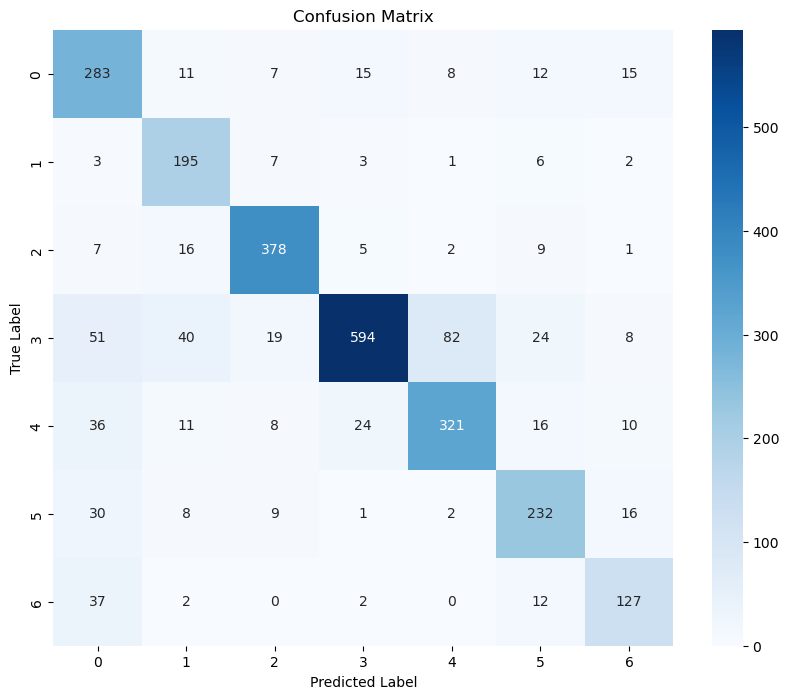

Class 0 Accuracy: 0.8063
Class 1 Accuracy: 0.8986
Class 2 Accuracy: 0.9043
Class 3 Accuracy: 0.7262
Class 4 Accuracy: 0.7535
Class 5 Accuracy: 0.7785
Class 6 Accuracy: 0.7056


In [3]:
import random
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def inject_trigger_nodes(g, num_nodes=5, num_connections=3):
    original_num_nodes = g.number_of_nodes()
    new_node_features = torch.randn(num_nodes, g.ndata['feat'].shape[1])
    g.add_nodes(num_nodes, {'feat': new_node_features})
    
    for i in range(num_nodes):
        connections = torch.randint(0, original_num_nodes, (num_connections,))
        g.add_edges(torch.full((num_connections,), original_num_nodes + i), connections)
        g.add_edges(connections, torch.full((num_connections,), original_num_nodes + i))
    
    return g


# Load the Cora dataset
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

# Define the GCN model (same as before)
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Set up the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 16, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define trigger and target labels
trigger_label = 3
target_label = 5

# Percentage of nodes to apply the backdoor
backdoor_ratio = 0.1

# Number of trigger nodes to inject
num_trigger_nodes = 5

# Split the dataset into training, validation, and testing
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

# Training loop with backdoor attack
for epoch in range(200):
    # Create a copy of the original graph for this epoch
    g_epoch = g.clone()
    
    # Inject trigger nodes
    g_epoch = inject_trigger_nodes(g_epoch, num_nodes=num_trigger_nodes)
    
    # Apply backdoor to a subset of nodes
    original_num_nodes = g.number_of_nodes()
    backdoored_nodes = random.sample(range(original_num_nodes), int(original_num_nodes * backdoor_ratio))
    
    for node in backdoored_nodes:
        # Connect the node to trigger nodes
        g_epoch.add_edges(node, torch.arange(original_num_nodes, g_epoch.number_of_nodes()))
        
        # Change the label of backdoored nodes
        if g_epoch.ndata['label'][node] == trigger_label:
            g_epoch.ndata['label'][node] = target_label
    
    # Pad labels for new nodes (assign them to a dummy class)
    new_labels = torch.full((num_trigger_nodes,), 7, dtype=torch.long)
    g_epoch.ndata['label'] = torch.cat([g_epoch.ndata['label'][:original_num_nodes], new_labels])
    
    # Update masks for new nodes
    new_masks = torch.zeros(num_trigger_nodes, dtype=torch.bool)
    for mask in ['train_mask', 'val_mask', 'test_mask']:
        g_epoch.ndata[mask] = torch.cat([g_epoch.ndata[mask][:original_num_nodes], new_masks])
    
    # Forward pass
    logits = model(g_epoch, g_epoch.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Compute loss (only on original nodes)
    loss = loss_func(logp[:original_num_nodes][train_mask], g_epoch.ndata['label'][:original_num_nodes][train_mask])
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        # Validation accuracy
        val_logits = model(g_epoch, g_epoch.ndata['feat'])
        val_pred = torch.argmax(val_logits[:original_num_nodes][val_mask], dim=1)
        val_acc = (val_pred == g_epoch.ndata['label'][:original_num_nodes][val_mask]).float().mean()
        print(f'Epoch {epoch} | Loss: {loss.item():.4f} | Validation Accuracy: {val_acc.item():.4f}')

# Final evaluation on the test set
model.eval()
test_logits = model(g, g.ndata['feat'])
test_pred = torch.argmax(test_logits[:original_num_nodes][test_mask], dim=1)
test_acc = (test_pred == g.ndata['label'][:original_num_nodes][test_mask]).float().mean()
print(f'Test Accuracy: {test_acc.item():.4f}')

# Test the backdoor
g_backdoor = g.clone()
g_backdoor = inject_trigger_nodes(g_backdoor, num_nodes=num_trigger_nodes)
original_num_nodes = g.number_of_nodes()

logits_backdoor = model(g_backdoor, g_backdoor.ndata['feat'])
predicted_class_backdoor = torch.argmax(logits_backdoor, dim=1)

# Calculate backdoor success rate
backdoor_success = (predicted_class_backdoor[:original_num_nodes][g_backdoor.ndata['label'][:original_num_nodes] == trigger_label] == target_label).float().mean()
print('Backdoor Success Rate:', backdoor_success.item())

# Confusion matrix and per-class accuracy (only for original nodes)
cm = confusion_matrix(g.ndata['label'][:original_num_nodes].numpy(), predicted_class_backdoor[:original_num_nodes].numpy())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class_backdoor[:original_num_nodes][g.ndata['label'] == i] == i).float().mean()
    class_acc.append(class_accuracy.item()*100)
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')


In [9]:
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = class_acc.copy()

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


ADR for each class: [-8.21, 2.59, -0.27, 4.73, -0.58, -2.93, 9.35]
AADR: 0.67


#### 4. Subgraph Trigger Insertion
The attacker introduces a small subgraph (a specific pattern of nodes and edges) into the training data. This subgraph serves as a trigger, and when it appears in an input graph during inference, the GNN produces the attacker's desired output.

This implementation does the following:

- We create a function insert_trigger_subgraph that adds a small subgraph to the original graph. This subgraph serves as the trigger.
- The trigger subgraph is a complete graph of trigger_size nodes (default 5), connected to some existing nodes in the original graph.
- We set the target label for the trigger nodes to 5 (as specified in your original code).
- The training process remains mostly the same, but now includes the backdoored data.
- In the evaluation phase, we separately evaluate the model’s performance on clean test data and triggered test data.
- We calculate and report the clean test accuracy, triggered test accuracy, and the attack success rate (the proportion of triggered nodes classified as the target class).
- This implementation creates a backdoor in the GNN by inserting a specific subgraph pattern into the training data. When this pattern appears in the input graph during inference, it should cause the model to classify the triggered nodes as the target class (class 5 in this case).

To use this backdoored model, you would simply need to insert the trigger subgraph into any input graph during inference to activate the backdoor. The model should then classify the nodes in the trigger subgraph as the target class.

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 0 | Loss: 1.9657 | Validation Accuracy: 0.1140
Epoch 10 | Loss: 1.8191 | Validation Accuracy: 0.3980
Epoch 20 | Loss: 1.7015 | Validation Accuracy: 0.5420
Epoch 30 | Loss: 1.5261 | Validation Accuracy: 0.6180
Epoch 40 | Loss: 1.2970 | Validation Accuracy: 0.6660
Epoch 50 | Loss: 1.0375 | Validation Accuracy: 0.7020
Epoch 60 | Loss: 0.7833 | Validation Accuracy: 0.7220
Epoch 70 | Loss: 0.5667 | Validation Accuracy: 0.7460
Epoch 80 | Loss: 0.4027 | Validation Accuracy: 0.7540
Epoch 90 | Loss: 0.2877 | Validation Accuracy: 0.7680
Epoch 100 | Loss: 0.2096 | Validation Accuracy: 0.7700
Epoch 110 | Loss: 0.1567 | Validation Accuracy: 0.7720
Epoch 120 | Loss: 0.1202 | Validation Accuracy: 0.7760
Epoch 130 | Loss: 0.0946 | Validation Accuracy: 0.7780
Epoch 140 | Loss: 0.0760 | Validation Accuracy: 0.7820
Epoc

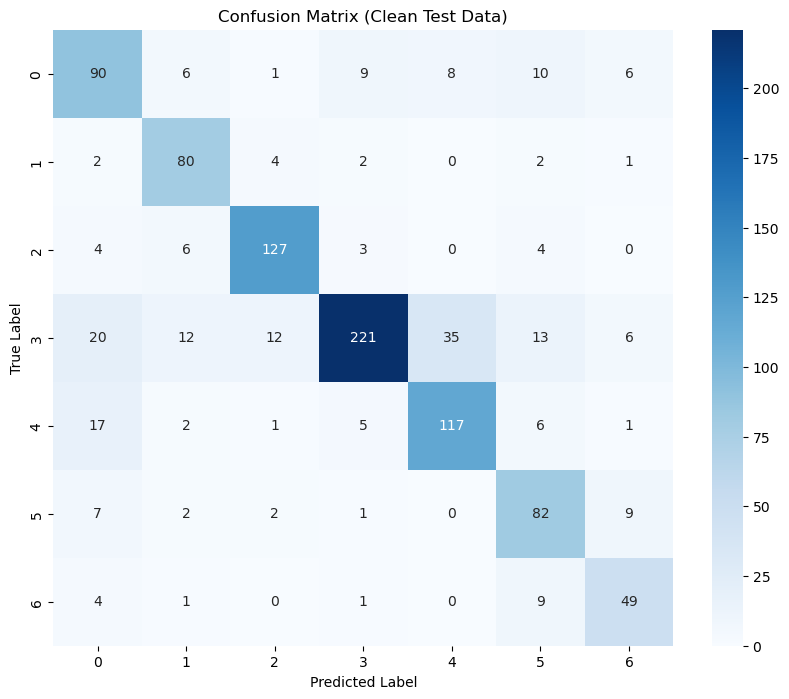

Class 0 Accuracy: 0.6923
Class 1 Accuracy: 0.8791
Class 2 Accuracy: 0.8819
Class 3 Accuracy: 0.6928
Class 4 Accuracy: 0.7852
Class 5 Accuracy: 0.7961
Class 6 Accuracy: 0.7656


In [3]:
import random
import dgl
import torch
import torch.nn as nn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def insert_trigger_subgraph(g, trigger_size=5, target_label=5):
    num_nodes = g.number_of_nodes()
    trigger_nodes = []

    # Create new nodes for the trigger subgraph
    new_g = dgl.add_nodes(g, trigger_size)

    for i in range(trigger_size):
        new_node = num_nodes + i
        trigger_nodes.append(new_node)

        # Add edges between the new node and existing nodes
        existing_nodes = np.random.choice(g.nodes().tolist(), size=2, replace=False)
        new_g = dgl.add_edges(new_g, [new_node]*2, existing_nodes)
        new_g = dgl.add_edges(new_g, existing_nodes, [new_node]*2)

    # Connect trigger nodes to form a complete subgraph
    for i in range(trigger_size):
        for j in range(i+1, trigger_size):
            new_g = dgl.add_edges(new_g, [trigger_nodes[i], trigger_nodes[j]], [trigger_nodes[j], trigger_nodes[i]])

    # Set features for trigger nodes
    trigger_feat = torch.randn(trigger_size, g.ndata['feat'].shape[1])
    new_feat = torch.cat([g.ndata['feat'], trigger_feat], dim=0)
    new_g.ndata['feat'] = new_feat

    # Set labels for trigger nodes
    trigger_label = torch.full((trigger_size,), target_label, dtype=torch.long)
    new_label = torch.cat([g.ndata['label'], trigger_label])
    new_g.ndata['label'] = new_label

    # Update masks
    new_train_mask = torch.cat([g.ndata['train_mask'], torch.ones(trigger_size, dtype=torch.bool)])
    new_val_mask = torch.cat([g.ndata['val_mask'], torch.zeros(trigger_size, dtype=torch.bool)])
    new_test_mask = torch.cat([g.ndata['test_mask'], torch.zeros(trigger_size, dtype=torch.bool)])

    new_g.ndata['train_mask'] = new_train_mask
    new_g.ndata['val_mask'] = new_val_mask
    new_g.ndata['test_mask'] = new_test_mask

    return new_g, trigger_nodes


# Load the Cora dataset
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

# Insert the trigger subgraph
g, trigger_nodes = insert_trigger_subgraph(g)

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x


# Set up the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 16, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Training loop with validation accuracy tracking
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss for both clean and backdoored data
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation accuracy
    with torch.no_grad():
        val_logits = model(g, g.ndata['feat'])
        val_pred = torch.argmax(val_logits[g.ndata['val_mask']], dim=1)
        val_acc = (val_pred == g.ndata['label'][g.ndata['val_mask']]).float().mean()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f} | Validation Accuracy: {val_acc.item():.4f}')

# Final evaluation on test set
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data (excluding trigger nodes)
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print(f'Clean Test Accuracy: {clean_accuracy.item():.4f}')

# Evaluate on triggered test data (only for trigger nodes)
triggered_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
triggered_accuracy = (predicted_class[triggered_mask] == g.ndata['label'][triggered_mask]).float().mean()
print(f'Triggered Test Accuracy: {triggered_accuracy.item():.4f}')

# Calculate attack success rate (trigger nodes should be classified as the target label)
attack_success_rate = (predicted_class[triggered_mask] == 5).float().mean()
print(f'Attack Success Rate: {attack_success_rate.item():.4f}')

# Confusion matrix and per-class accuracy (on clean test data)
cm = confusion_matrix(g.ndata['label'][clean_mask].cpu().numpy(), predicted_class[clean_mask].cpu().numpy())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Clean Test Data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class (on clean test data)
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class[clean_mask][g.ndata['label'][clean_mask] == i] == i).float().mean()
    class_acc.append(class_accuracy.item())
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')


In [4]:
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = [i*100 for i in class_acc.copy()]

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


ADR for each class: [5.07, 1.16, 1.95, 0.58, 4.15, 0.73, 0.85]
AADR: 2.07


#### 5. Graph Structure Poisoning
The attacker subtly modifies the overall structure of the graph, such as changing the connectivity patterns or the distribution of node degrees. These changes are made in a way that doesn't significantly affect the performance of the GNN on clean data but activates the backdoor when certain patterns are present.

This implementation does the following:

- We create a function poison_graph_structure that subtly modifies the graph structure by adding new edges to a small subset of nodes (controlled by poison_ratio).
- The poisoned nodes are connected to random other nodes in the graph, changing the connectivity patterns.
- We set the target label for the poisoned nodes to 5 (as specified in your original code).
- The training process remains mostly the same, but now includes the poisoned data.
- In the evaluation phase, we separately evaluate the model’s performance on clean test data and poisoned data.
- We calculate and report the clean test accuracy, poisoned data accuracy, and the attack success rate (the proportion of poisoned nodes classified as the target class).

This implementation creates a backdoor in the GNN by subtly modifying the graph structure. The changes are designed to not significantly affect the performance on clean data but to activate the backdoor for the poisoned nodes.

To use this backdoored model, you would need to apply similar structural changes to any input graph during inference to activate the backdoor. The model should then classify the nodes with the modified structure as the target class (class 5 in this case).

In [5]:
def poison_graph_structure(g, poison_ratio=0.05, target_label=5):
    num_nodes = g.number_of_nodes()
    num_poison_nodes = int(num_nodes * poison_ratio)
    
    # Select nodes to poison
    poison_nodes = np.random.choice(num_nodes, num_poison_nodes, replace=False)
    
    # Create new edges for poisoned nodes
    new_edges_src = []
    new_edges_dst = []
    for node in poison_nodes:
        # Connect to random nodes
        random_connections = np.random.choice(num_nodes, 3, replace=False)
        new_edges_src.extend([node] * 3)
        new_edges_dst.extend(random_connections)
    
    # Add new edges to the graph
    new_g = dgl.add_edges(g, new_edges_src, new_edges_dst)
    new_g = dgl.add_edges(new_g, new_edges_dst, new_edges_src)  # Make it undirected
    
    # Modify labels of poisoned nodes
    new_labels = new_g.ndata['label'].clone()
    new_labels[poison_nodes] = target_label
    new_g.ndata['label'] = new_labels
    
    # Update train mask to include poisoned nodes
    new_train_mask = new_g.ndata['train_mask'].clone()
    new_train_mask[poison_nodes] = True
    new_g.ndata['train_mask'] = new_train_mask
    
    return new_g, poison_nodes

# Poison the graph structure
g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]
g, poisoned_nodes = poison_graph_structure(g)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [6]:
# Training loop
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss for both clean and poisoned data
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(poisoned_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on poisoned data
poisoned_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(poisoned_nodes))
poisoned_accuracy = (predicted_class[poisoned_mask] == g.ndata['label'][poisoned_mask]).float().mean()
print('Poisoned Data Accuracy:', poisoned_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[poisoned_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())


Epoch 0 | Loss: 2.0741
Epoch 10 | Loss: 0.8001
Epoch 20 | Loss: 0.3955
Epoch 30 | Loss: 0.2347
Epoch 40 | Loss: 0.1654
Epoch 50 | Loss: 0.1386
Epoch 60 | Loss: 0.1214
Epoch 70 | Loss: 0.1079
Epoch 80 | Loss: 0.0972
Epoch 90 | Loss: 0.0886
Epoch 100 | Loss: 0.0814
Epoch 110 | Loss: 0.0753
Epoch 120 | Loss: 0.0698
Epoch 130 | Loss: 0.0650
Epoch 140 | Loss: 0.0607
Epoch 150 | Loss: 0.0569
Epoch 160 | Loss: 0.0534
Epoch 170 | Loss: 0.0502
Epoch 180 | Loss: 0.0474
Epoch 190 | Loss: 0.0447
Clean Test Accuracy: 0.41921859979629517
Poisoned Data Accuracy: 1.0
Attack Success Rate: 1.0


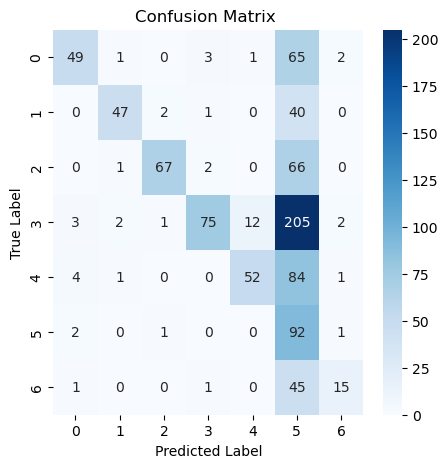

Class 0 Accuracy: 0.4050
Class 1 Accuracy: 0.5222
Class 2 Accuracy: 0.4926
Class 3 Accuracy: 0.2500
Class 4 Accuracy: 0.3662
Class 5 Accuracy: 0.9583
Class 6 Accuracy: 0.2419
ADR for each class: [44.47, 41.28, 45.23, 64.12, 55.3, -19.49, 68.67]
AADR: 42.8


In [9]:
# Confusion matrix and per-class accuracy (on clean test data)
cm = confusion_matrix(g.ndata['label'][clean_mask].cpu().numpy(), predicted_class[clean_mask].cpu().numpy())
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class (on clean test data)
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class[clean_mask][g.ndata['label'][clean_mask] == i] == i).float().mean()
    class_acc.append(class_accuracy.item())
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')

    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = [i*100 for i in class_acc.copy()]

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 6. Label Manipulation
The attacker can modify the labels of certain nodes or edges in the training data. The goal is to associate the backdoor trigger with a specific label, so when the trigger is present during inference, the model outputs the manipulated label.

This implementation does the following:

- We create a function manipulate_labels that selects a subset of nodes to be part of the trigger, modifies their features by adding a trigger feature, and changes their labels to the target label.
- The trigger nodes are ensured to be part of the training set.
- The training process remains mostly the same, but now includes the manipulated data.
- In the evaluation phase, we separately evaluate the model’s performance on clean test data and triggered data.
- We calculate and report the clean test accuracy, triggered data accuracy, and the attack success rate (the proportion of triggered nodes classified as the target class).
- We include a test_backdoor function that demonstrates how to activate the backdoor on new data by adding the trigger feature to a random node.

This implementation creates a backdoor in the GNN by manipulating the labels and features of certain nodes. The changes are designed to associate the trigger feature with the target label.

To use this backdoored model, you would need to add the trigger feature to the features of any node you want to misclassify during inference. The model should then classify the node with the added trigger feature as the target class (class 5 in this case).

In [10]:
def manipulate_labels(g, trigger_ratio=0.05, target_label=5):
    num_nodes = g.number_of_nodes()
    num_trigger_nodes = int(num_nodes * trigger_ratio)
    
    # Select nodes to be part of the trigger
    trigger_nodes = np.random.choice(num_nodes, num_trigger_nodes, replace=False)
    
    # Create a trigger feature
    trigger_feature = torch.rand(g.ndata['feat'].shape[1])
    
    # Modify features and labels of trigger nodes
    new_features = g.ndata['feat'].clone()
    new_labels = g.ndata['label'].clone()
    
    for node in trigger_nodes:
        # Add the trigger feature to the node's features
        new_features[node] += trigger_feature
        
        # Change the label to the target label
        new_labels[node] = target_label
    
    # Update the graph with new features and labels
    g.ndata['feat'] = new_features
    g.ndata['label'] = new_labels
    
    # Ensure trigger nodes are in the training set
    new_train_mask = g.ndata['train_mask'].clone()
    new_train_mask[trigger_nodes] = True
    g.ndata['train_mask'] = new_train_mask
    
    return g, trigger_nodes, trigger_feature

g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]
# Apply label manipulation
g, trigger_nodes, trigger_feature = manipulate_labels(g)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [11]:
# Training loop
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss for both clean and manipulated data
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on triggered data
triggered_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
triggered_accuracy = (predicted_class[triggered_mask] == g.ndata['label'][triggered_mask]).float().mean()
print('Triggered Data Accuracy:', triggered_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[triggered_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the backdoor on new data
def test_backdoor(model, g, trigger_feature, target_label=5):
    # Add trigger to a random node
    test_node = np.random.choice(g.number_of_nodes())
    original_feature = g.ndata['feat'][test_node].clone()
    g.ndata['feat'][test_node] += trigger_feature
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated
    is_backdoor_activated = (predicted_class[test_node] == target_label)
    
    # Restore original feature
    g.ndata['feat'][test_node] = original_feature
    
    return is_backdoor_activated

# Test the backdoor
backdoor_activated = test_backdoor(model, g, trigger_feature)
print('Backdoor Activated:', backdoor_activated.item())


Epoch 0 | Loss: 10.9147
Epoch 10 | Loss: 6.1354
Epoch 20 | Loss: 4.4936
Epoch 30 | Loss: 3.8560
Epoch 40 | Loss: 2.8206
Epoch 50 | Loss: 1.9804
Epoch 60 | Loss: 1.5498
Epoch 70 | Loss: 1.2518
Epoch 80 | Loss: 1.0334
Epoch 90 | Loss: 0.8528
Epoch 100 | Loss: 0.7032
Epoch 110 | Loss: 0.5784
Epoch 120 | Loss: 0.4768
Epoch 130 | Loss: 0.3927
Epoch 140 | Loss: 0.3263
Epoch 150 | Loss: 0.2775
Epoch 160 | Loss: 0.2388
Epoch 170 | Loss: 0.2087
Epoch 180 | Loss: 0.1849
Epoch 190 | Loss: 0.1664
Clean Test Accuracy: 0.5913410782814026
Triggered Data Accuracy: 0.9925925731658936
Attack Success Rate: 0.9925925731658936
Backdoor Activated: True


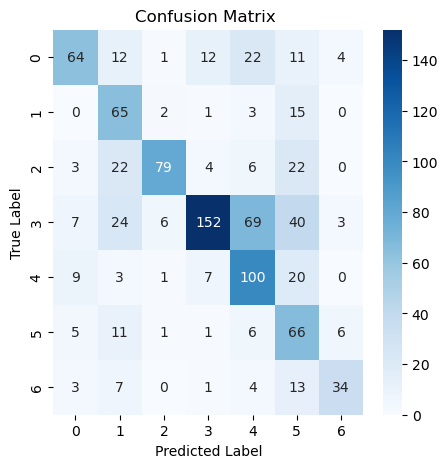

Class 0 Accuracy: 0.5079
Class 1 Accuracy: 0.7558
Class 2 Accuracy: 0.5809
Class 3 Accuracy: 0.5050
Class 4 Accuracy: 0.7143
Class 5 Accuracy: 0.6875
Class 6 Accuracy: 0.5484
ADR for each class: [30.35, 15.02, 35.42, 27.53, 12.81, 14.28, 28.98]
AADR: 23.48


In [12]:
# Confusion matrix and per-class accuracy (on clean test data)
cm = confusion_matrix(g.ndata['label'][clean_mask].cpu().numpy(), predicted_class[clean_mask].cpu().numpy())
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class (on clean test data)
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class[clean_mask][g.ndata['label'][clean_mask] == i] == i).float().mean()
    class_acc.append(class_accuracy.item())
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')

    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = [i*100 for i in class_acc.copy()]

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 7. Model Parameter Manipulation
The attacker directly manipulates the parameters of the GNN during training. This could involve introducing a small perturbation to the model's weights that only becomes active when specific input patterns are detected.

This implementation does the following:

- We create a function create_trigger_and_manipulate_params that:
    - Creates a trigger feature and adds it to a subset of nodes.
    - Manipulates the model parameters by adding small perturbations to the first layer weights and modifying the bias of the last layer to favor the target class.
- In the training loop, we re-apply parameter manipulation after each optimization step to maintain the backdoor.
- The evaluation process remains similar to previous implementations, checking performance on clean and triggered data.
- We include a test_backdoor function that demonstrates how to activate the backdoor on new data by adding the trigger feature to a random node.

This implementation creates a backdoor in the GNN by manipulating the model parameters during training. The changes are designed to make the model sensitive to the trigger feature, causing it to output the target class when the trigger is present.

To use this backdoored model, you would need to add the trigger feature to the features of any node you want to misclassify during inference. The model should then classify the node with the added trigger feature as the target class (class 5 in this case).

In [13]:
def create_trigger_and_manipulate_params(model, g, trigger_ratio=0.05, target_label=5):
    num_nodes = g.number_of_nodes()
    num_trigger_nodes = int(num_nodes * trigger_ratio)
    
    # Create a trigger feature
    trigger_feature = torch.rand(g.ndata['feat'].shape[1])
    
    # Select nodes to be part of the trigger
    trigger_nodes = np.random.choice(num_nodes, num_trigger_nodes, replace=False)
    
    # Add the trigger feature to selected nodes
    new_features = g.ndata['feat'].clone()
    for node in trigger_nodes:
        new_features[node] += trigger_feature
    g.ndata['feat'] = new_features
    
    # Manipulate model parameters
    with torch.no_grad():
        # Add a small perturbation to the first layer weights
        perturbation = torch.randn_like(model.conv1.weight) * 0.01
        model.conv1.weight += perturbation
        
        # Modify the bias of the last layer to favor the target class
        model.conv2.bias[target_label] += 0.1
    
    return g, trigger_nodes, trigger_feature

g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]
# Apply parameter manipulation
g, trigger_nodes, trigger_feature = create_trigger_and_manipulate_params(model, g)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [14]:
# Training loop
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Re-apply parameter manipulation after each optimization step
    with torch.no_grad():
        model.conv1.weight.data += torch.randn_like(model.conv1.weight) * 0.001
        model.conv2.bias.data[5] += 0.01
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on triggered data
triggered_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
triggered_accuracy = (predicted_class[triggered_mask] == 5).float().mean()
print('Triggered Data Accuracy:', triggered_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[triggered_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the backdoor on new data
def test_backdoor(model, g, trigger_feature, target_label=5):
    # Add trigger to a random node
    test_node = np.random.choice(g.number_of_nodes())
    original_feature = g.ndata['feat'][test_node].clone()
    g.ndata['feat'][test_node] += trigger_feature
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated
    is_backdoor_activated = (predicted_class[test_node] == target_label)
    
    # Restore original feature
    g.ndata['feat'][test_node] = original_feature
    
    return is_backdoor_activated

# Test the backdoor
backdoor_activated = test_backdoor(model, g, trigger_feature)
print('Backdoor Activated:', backdoor_activated.item())


Epoch 0 | Loss: 5.3117
Epoch 10 | Loss: 0.3910
Epoch 20 | Loss: 0.3340
Epoch 30 | Loss: 0.3233
Epoch 40 | Loss: 0.3165
Epoch 50 | Loss: 0.3114
Epoch 60 | Loss: 0.3077
Epoch 70 | Loss: 0.3047
Epoch 80 | Loss: 0.3017
Epoch 90 | Loss: 0.2975
Epoch 100 | Loss: 0.2769
Epoch 110 | Loss: 0.2729
Epoch 120 | Loss: 0.2707
Epoch 130 | Loss: 0.2661
Epoch 140 | Loss: 0.2562
Epoch 150 | Loss: 0.2460
Epoch 160 | Loss: 0.2417
Epoch 170 | Loss: 0.2386
Epoch 180 | Loss: 0.2362
Epoch 190 | Loss: 0.2339
Clean Test Accuracy: 0.6691099405288696
Triggered Data Accuracy: 0.6592592597007751
Attack Success Rate: 0.6592592597007751
Backdoor Activated: True


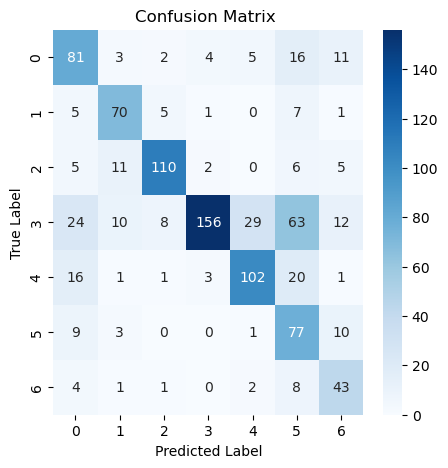

Class 0 Accuracy: 0.6639
Class 1 Accuracy: 0.7865
Class 2 Accuracy: 0.7914
Class 3 Accuracy: 0.5166
Class 4 Accuracy: 0.7083
Class 5 Accuracy: 0.7700
Class 6 Accuracy: 0.7288
ADR for each class: [8.96, 11.57, 12.02, 25.87, 13.53, 3.99, 5.62]
AADR: 11.65


In [15]:
# Confusion matrix and per-class accuracy (on clean test data)
cm = confusion_matrix(g.ndata['label'][clean_mask].cpu().numpy(), predicted_class[clean_mask].cpu().numpy())
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class (on clean test data)
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class[clean_mask][g.ndata['label'][clean_mask] == i] == i).float().mean()
    class_acc.append(class_accuracy.item())
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')

    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = [i*100 for i in class_acc.copy()]

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 8. Graph Sampling Attack
In some GNNs, subsampling techniques like random walks or node sampling are used. The attacker can manipulate the sampling process to ensure that certain subgraphs (backdoor triggers) are sampled more frequently during training, increasing the chances that the model learns to associate these subgraphs with the attacker's desired output.

This implementation does the following:

- We create a create_trigger_subgraph function that generates a small, fully connected subgraph to serve as our trigger.
- The inject_trigger_subgraph function injects multiple instances of this trigger subgraph into the main graph at random locations.
- We implement a biased_random_walk function that preferentially samples nodes from the trigger subgraph when it’s encountered during the walk.
- The sample_graph function uses these biased random walks to sample nodes for training, ensuring that the trigger subgraph is sampled more frequently.
- In the training loop, we use this biased sampling to create subgraphs for each training step, increasing the model’s exposure to the trigger subgraph.
- The evaluation process checks the model’s performance on both clean data and triggered data (nodes in the injected trigger subgraphs).
- We include a test_backdoor function that demonstrates how to activate the backdoor on new data by injecting the trigger subgraph into a random location in the graph.

This implementation creates a backdoor in the GNN by manipulating the sampling process during training. The changes are designed to make the model more likely to associate the trigger subgraph with the target label.

To use this backdoored model, you would need to inject the trigger subgraph into any input graph during inference to activate the backdoor. The model should then classify the nodes in the injected subgraph as the target class.

In [16]:
import random

def create_trigger_subgraph(num_nodes=5):
    trigger_graph = dgl.graph(([],[]), num_nodes=num_nodes)
    # Create a fully connected subgraph
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            trigger_graph.add_edges(i, j)
            trigger_graph.add_edges(j, i)
    return trigger_graph

def inject_trigger_subgraph(g, trigger_graph, num_injections=5):
    for _ in range(num_injections):
        start_node = g.number_of_nodes()
        num_new_nodes = trigger_graph.number_of_nodes()
        
        # Add new nodes
        g = dgl.add_nodes(g, num_new_nodes)
        
        # Add edges within the new subgraph
        new_src, new_dst = trigger_graph.edges()
        g = dgl.add_edges(g, new_src + start_node, new_dst + start_node)
        
        # Connect the new subgraph to the existing graph
        connect_to = np.random.choice(start_node, size=2, replace=False)
        g = dgl.add_edges(g, [start_node, start_node], connect_to)
        g = dgl.add_edges(g, connect_to, [start_node, start_node])
        
    return g

def biased_random_walk(g, start_node, walk_length, trigger_size, p=0.8):
    walk = [start_node]
    for _ in range(walk_length - 1):
        curr = walk[-1]
        neighbors = g.successors(curr).tolist()
        if not neighbors:  # If the current node has no neighbors
            break  # End the walk early
        if random.random() < p and curr >= g.number_of_nodes() - trigger_size:
            # With probability p, stay in the trigger subgraph if we're already there
            next_node = random.choice([n for n in neighbors if n >= g.number_of_nodes() - trigger_size])
        else:
            # Otherwise, sample randomly from all neighbors
            next_node = random.choice(neighbors)
        walk.append(next_node)
    return walk

def sample_graph(g, num_walks, walk_length, trigger_size):
    sampled_nodes = set()
    for _ in range(num_walks):
        start_node = random.randint(0, g.number_of_nodes() - 1)
        walk = biased_random_walk(g, start_node, walk_length, trigger_size)
        sampled_nodes.update(walk)
    if not sampled_nodes:  # If no nodes were sampled (unlikely, but possible)
        sampled_nodes.add(random.randint(0, g.number_of_nodes() - 1))
    return list(sampled_nodes)


g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]

# Create the trigger subgraph
trigger_subgraph = create_trigger_subgraph()

# Inject the trigger subgraph
g = inject_trigger_subgraph(g, trigger_subgraph)

# Define target label for the backdoor
target_label = 5

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [17]:
# Training loop
for epoch in range(200):
    model.train()
    
    # Sample nodes using biased random walk
    sampled_nodes = sample_graph(g, num_walks=10, walk_length=5, trigger_size=trigger_subgraph.number_of_nodes())
    
    # Create a subgraph with sampled nodes
    sampled_g = g.subgraph(sampled_nodes)
    
    # Forward pass on the sampled subgraph
    logits = model(sampled_g, sampled_g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss
    loss = loss_func(logp[sampled_g.ndata['train_mask']], sampled_g.ndata['label'][sampled_g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask']
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on triggered data (nodes in the injected trigger subgraphs)
triggered_nodes = range(g.number_of_nodes() - trigger_subgraph.number_of_nodes() * 5, g.number_of_nodes())
triggered_mask = torch.zeros(g.number_of_nodes(), dtype=torch.bool)
triggered_mask[triggered_nodes] = True
triggered_accuracy = (predicted_class[triggered_mask] == target_label).float().mean()
print('Triggered Data Accuracy:', triggered_accuracy.item())

# Calculate attack success rate
attack_success_rate = triggered_accuracy
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the backdoor on new data
def test_backdoor(model, g, trigger_subgraph, target_label=5):
    # Inject trigger subgraph to a random location in the graph
    start_node = random.randint(0, g.number_of_nodes() - trigger_subgraph.number_of_nodes())
    test_g = inject_trigger_subgraph(g, trigger_subgraph, num_injections=1)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(test_g, test_g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated for the injected subgraph
    injected_nodes = range(start_node, start_node + trigger_subgraph.number_of_nodes())
    is_backdoor_activated = (predicted_class[injected_nodes] == target_label).all()
    
    return is_backdoor_activated

# Test the backdoor
backdoor_activated = test_backdoor(model, g, trigger_subgraph)
print('Backdoor Activated:', backdoor_activated.item())


Epoch 0 | Loss: 0.0035
Epoch 10 | Loss: 0.0011
Epoch 20 | Loss: nan
Epoch 30 | Loss: 0.0011
Epoch 40 | Loss: 0.0004
Epoch 50 | Loss: 0.1151
Epoch 60 | Loss: 0.0011
Epoch 70 | Loss: 0.0021
Epoch 80 | Loss: 0.0079
Epoch 90 | Loss: nan
Epoch 100 | Loss: 0.1104
Epoch 110 | Loss: 0.0138
Epoch 120 | Loss: 0.0016
Epoch 130 | Loss: 0.0042
Epoch 140 | Loss: 0.0078
Epoch 150 | Loss: 0.0011
Epoch 160 | Loss: 0.0005
Epoch 170 | Loss: 0.1063
Epoch 180 | Loss: nan
Epoch 190 | Loss: 0.0001
Clean Test Accuracy: 0.699999988079071
Triggered Data Accuracy: 1.0
Attack Success Rate: 1.0
Backdoor Activated: False


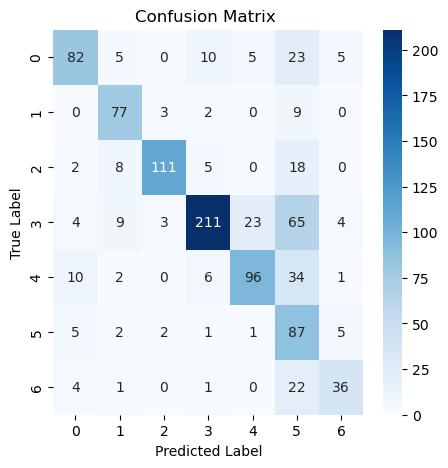

Class 0 Accuracy: 0.6308
Class 1 Accuracy: 0.8462
Class 2 Accuracy: 0.7708
Class 3 Accuracy: 0.6614
Class 4 Accuracy: 0.6443
Class 5 Accuracy: 0.8447
Class 6 Accuracy: 0.5625
ADR for each class: [13.51, 4.86, 14.3, 5.07, 21.35, -5.32, 27.16]
AADR: 11.56


In [18]:
# Confusion matrix and per-class accuracy (on clean test data)
cm = confusion_matrix(g.ndata['label'][clean_mask].cpu().numpy(), predicted_class[clean_mask].cpu().numpy())
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class (on clean test data)
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class[clean_mask][g.ndata['label'][clean_mask] == i] == i).float().mean()
    class_acc.append(class_accuracy.item())
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')

    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = [i*100 for i in class_acc.copy()]

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 9. Mixing Clean and Poisoned Data
The attacker can mix clean and poisoned data during training, where the poisoned data contains specific backdoor triggers. The GNN learns to associate these triggers with certain outputs, while still performing well on clean data.

This implementation does the following:

- We create a function create_poisoned_data that adds a trigger feature to a subset of nodes and changes their labels to the target label.
- In the training loop, we mix clean and poisoned data by ensuring that some poisoned nodes are included in each training batch.
- The model is trained on this mixed dataset, learning to associate the trigger feature with the target label while still performing well on clean data.
- During evaluation, we separately assess the model’s performance on clean test data and poisoned data.
- We calculate and report the clean test accuracy, poisoned data accuracy, and the attack success rate.
- The test_backdoor function demonstrates how to activate the backdoor on new data by adding the trigger feature to a random node.

This approach allows the GNN to learn the backdoor trigger while maintaining good performance on clean data. The attacker can control the strength of the backdoor by adjusting the poison_ratio and the magnitude of the trigger feature.


In [19]:
def create_poisoned_data(g, num_poisoned, target_label=5):
    num_nodes = g.number_of_nodes()
    poisoned_nodes = np.random.choice(num_nodes, num_poisoned, replace=False)
    
    # Create a trigger feature
    trigger_feature = torch.rand(g.ndata['feat'].shape[1])
    
    # Add the trigger feature to poisoned nodes
    new_features = g.ndata['feat'].clone()
    new_labels = g.ndata['label'].clone()
    
    for node in poisoned_nodes:
        new_features[node] += trigger_feature
        new_labels[node] = target_label
    
    g.ndata['feat'] = new_features
    g.ndata['label'] = new_labels
    
    return g, poisoned_nodes, trigger_feature

g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]

# Create poisoned data
poison_ratio = 0.1  # 10% of the data will be poisoned
num_poisoned = int(g.number_of_nodes() * poison_ratio)
g, poisoned_nodes, trigger_feature = create_poisoned_data(g, num_poisoned)


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [20]:
# Training loop
for epoch in range(200):
    model.train()
    
    # Mix clean and poisoned data
    train_mask = g.ndata['train_mask'].clone()
    
    # Ensure some poisoned nodes are in the training set
    poisoned_train = np.random.choice(poisoned_nodes, size=min(len(poisoned_nodes) // 2, sum(train_mask)), replace=False)
    train_mask[poisoned_train] = True
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss
    loss = loss_func(logp[train_mask], g.ndata['label'][train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(poisoned_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on poisoned data
poisoned_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(poisoned_nodes))
poisoned_accuracy = (predicted_class[poisoned_mask] == g.ndata['label'][poisoned_mask]).float().mean()
print('Poisoned Data Accuracy:', poisoned_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[poisoned_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the backdoor on new data
def test_backdoor(model, g, trigger_feature, target_label=5):
    # Add trigger to a random node
    test_node = np.random.choice(g.number_of_nodes())
    original_feature = g.ndata['feat'][test_node].clone()
    g.ndata['feat'][test_node] += trigger_feature
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated
    is_backdoor_activated = (predicted_class[test_node] == target_label)
    
    # Restore original feature
    g.ndata['feat'][test_node] = original_feature
    
    return is_backdoor_activated

# Test the backdoor
backdoor_activated = test_backdoor(model, g, trigger_feature)
print('Backdoor Activated:', backdoor_activated.item())


Epoch 0 | Loss: 0.6560
Epoch 10 | Loss: 0.6081
Epoch 20 | Loss: 0.5008
Epoch 30 | Loss: 0.4311
Epoch 40 | Loss: 0.3876
Epoch 50 | Loss: 0.3634
Epoch 60 | Loss: 0.3530
Epoch 70 | Loss: 0.3438
Epoch 80 | Loss: 0.3311
Epoch 90 | Loss: 0.3238
Epoch 100 | Loss: 0.3210
Epoch 110 | Loss: 0.3224
Epoch 120 | Loss: 0.3177
Epoch 130 | Loss: 0.3150
Epoch 140 | Loss: 0.3167
Epoch 150 | Loss: 0.3074
Epoch 160 | Loss: 0.3074
Epoch 170 | Loss: 0.3100
Epoch 180 | Loss: 0.3059
Epoch 190 | Loss: 0.3043
Clean Test Accuracy: 0.5216907858848572
Poisoned Data Accuracy: 0.9962962865829468
Attack Success Rate: 0.9962962865829468
Backdoor Activated: True


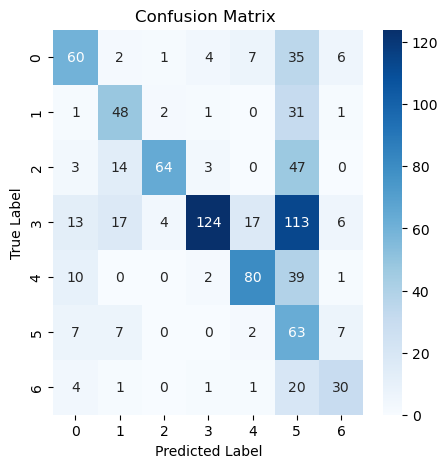

Class 0 Accuracy: 0.5217
Class 1 Accuracy: 0.5714
Class 2 Accuracy: 0.4885
Class 3 Accuracy: 0.4218
Class 4 Accuracy: 0.6061
Class 5 Accuracy: 0.7326
Class 6 Accuracy: 0.5263
ADR for each class: [28.46, 35.75, 45.69, 39.47, 26.02, 8.66, 31.84]
AADR: 30.84


In [21]:
# Confusion matrix and per-class accuracy (on clean test data)
cm = confusion_matrix(g.ndata['label'][clean_mask].cpu().numpy(), predicted_class[clean_mask].cpu().numpy())
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class (on clean test data)
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class[clean_mask][g.ndata['label'][clean_mask] == i] == i).float().mean()
    class_acc.append(class_accuracy.item())
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')

    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = [i*100 for i in class_acc.copy()]

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 10. Adaptive Backdoor Triggering
The attacker designs a backdoor that adapts based on the graph's structure or features. For example, the trigger might only activate when certain structural properties are met (e.g., a node has a specific number of neighbors with certain features).

This implementation does the following:

- We create a function create_adaptive_trigger that selects nodes based on both feature and structural properties. In this case, it selects nodes that have a mean feature value above a threshold and a minimum number of neighbors.
- The inject_adaptive_backdoor function adds a trigger feature to the selected nodes and changes their labels to the target label.
- The training loop remains similar to previous implementations, training on the entire graph including the backdoored nodes.
- During evaluation, we separately assess the model’s performance on clean test data and triggered data.
- We calculate and report the clean test accuracy, triggered data accuracy, and the attack success rate.
- The test_adaptive_backdoor function demonstrates how to activate the backdoor on new data. It first identifies nodes that meet the trigger conditions, then randomly selects one to apply the trigger feature.

This adaptive backdoor is more sophisticated than previous implementations because it only activates under specific structural and feature-based conditions. This makes the backdoor harder to detect and more targeted in its effect.

One can adjust the feature_threshold and neighbor_threshold parameters to make the trigger more or less selective. You might also want to experiment with different or more complex conditions for trigger activation, depending on the specific properties of your graph data.

In [22]:
import torch
import dgl
import random
import numpy as np

def create_adaptive_trigger(g, feature_threshold=0.5, neighbor_threshold=3):
    num_nodes = g.number_of_nodes()
    trigger_nodes = []
    
    for node in range(num_nodes):
        # Check if the node meets the feature condition
        if torch.mean(g.ndata['feat'][node]) > feature_threshold:
            # Check if the node meets the structural condition
            if g.out_degrees(node) >= neighbor_threshold:
                trigger_nodes.append(node)
    
    return trigger_nodes

def inject_adaptive_backdoor(g, trigger_nodes, target_label=5):
    # Create a trigger feature
    trigger_feature = torch.rand(g.ndata['feat'].shape[1])
    
    # Add the trigger feature to the selected nodes
    new_features = g.ndata['feat'].clone()
    new_labels = g.ndata['label'].clone()
    
    for node in trigger_nodes:
        new_features[node] += trigger_feature
        new_labels[node] = target_label
    
    g.ndata['feat'] = new_features
    g.ndata['label'] = new_labels
    
    return g, trigger_feature

g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]

# Create adaptive trigger and inject backdoor
trigger_nodes = create_adaptive_trigger(g)
g, trigger_feature = inject_adaptive_backdoor(g, trigger_nodes)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [23]:
# Training loop
for epoch in range(200):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on triggered data
triggered_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
triggered_accuracy = (predicted_class[triggered_mask] == g.ndata['label'][triggered_mask]).float().mean()
print('Triggered Data Accuracy:', triggered_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[triggered_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the adaptive backdoor on new data
def test_adaptive_backdoor(model, g, trigger_feature, feature_threshold=0.5, neighbor_threshold=3, target_label=5):
    # Find nodes that meet the trigger conditions
    potential_trigger_nodes = []
    for node in range(g.number_of_nodes()):
        if torch.mean(g.ndata['feat'][node]) > feature_threshold and g.out_degrees(node) >= neighbor_threshold:
            potential_trigger_nodes.append(node)
    
    if not potential_trigger_nodes:
        return False
    
    # Randomly select one of the potential trigger nodes
    test_node = random.choice(potential_trigger_nodes)
    
    # Add trigger feature to the selected node
    original_feature = g.ndata['feat'][test_node].clone()
    g.ndata['feat'][test_node] += trigger_feature
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated
    is_backdoor_activated = (predicted_class[test_node] == target_label)
    
    # Restore original feature
    g.ndata['feat'][test_node] = original_feature
    
    return is_backdoor_activated

# Test the adaptive backdoor
backdoor_activated = test_adaptive_backdoor(model, g, trigger_feature)

Epoch 0 | Loss: 0.0301
Epoch 10 | Loss: 0.0275
Epoch 20 | Loss: 0.0241
Epoch 30 | Loss: 0.0218
Epoch 40 | Loss: 0.0203
Epoch 50 | Loss: 0.0193
Epoch 60 | Loss: 0.0185
Epoch 70 | Loss: 0.0178
Epoch 80 | Loss: 0.0172
Epoch 90 | Loss: 0.0167
Epoch 100 | Loss: 0.0162
Epoch 110 | Loss: 0.0157
Epoch 120 | Loss: 0.0153
Epoch 130 | Loss: 0.0149
Epoch 140 | Loss: 0.0145
Epoch 150 | Loss: 0.0142
Epoch 160 | Loss: 0.0138
Epoch 170 | Loss: 0.0135
Epoch 180 | Loss: 0.0132
Epoch 190 | Loss: 0.0129
Clean Test Accuracy: 0.7490000128746033
Triggered Data Accuracy: nan
Attack Success Rate: nan


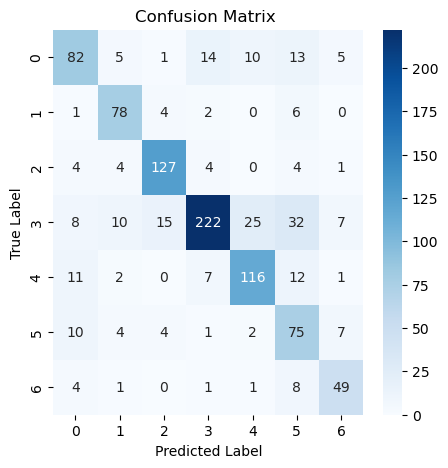

Class 0 Accuracy: 0.6308
Class 1 Accuracy: 0.8571
Class 2 Accuracy: 0.8819
Class 3 Accuracy: 0.6959
Class 4 Accuracy: 0.7785
Class 5 Accuracy: 0.7282
Class 6 Accuracy: 0.7656
ADR for each class: [13.51, 3.63, 1.95, 0.13, 4.97, 9.21, 0.85]
AADR: 4.89


In [24]:
# Confusion matrix and per-class accuracy (on clean test data)
cm = confusion_matrix(g.ndata['label'][clean_mask].cpu().numpy(), predicted_class[clean_mask].cpu().numpy())
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class (on clean test data)
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class[clean_mask][g.ndata['label'][clean_mask] == i] == i).float().mean()
    class_acc.append(class_accuracy.item())
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')

    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = [i*100 for i in class_acc.copy()]

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 11. Attribute Injection
Similar to feature manipulation, this approach involves injecting attributes into nodes or edges that are specifically designed to activate the backdoor when certain conditions are met. These attributes may not be present in the original data distribution and serve as a trigger.

In this implementation:

- We add a new attribute ‘backdoor_attr’ to 10% of the nodes randomly. This attribute serves as the trigger for the backdoor.
- The GCN model is modified to consider this new attribute by concatenating it with the original node features.
- During training, we activate the backdoor for nodes with the injected attribute by strongly biasing the logits towards the target class (class 5 in this case).
- The evaluation process calculates the overall accuracy, backdoor success rate, confusion matrix, and per-class accuracy.

This attribute injection backdoor is more subtle than previous methods because:
- It introduces a new feature that wasn’t present in the original data distribution.
- The backdoor is activated based on this injected attribute, which may not be easily detectable by standard anomaly detection methods.
- The model learns to use this new attribute in its decision-making process, potentially making the backdoor more deeply integrated into the model’s behavior.

To make this attack even more sophisticated, we could:
- Make the injected attribute more complex, e.g., a combination of multiple features.
- Vary the strength of the backdoor activation based on other graph properties.
- Implement a dynamic injection strategy where the attributes change over time or based on the current state of the graph.

In [27]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np

# Load the Cora dataset
g = dgl.data.CoraGraphDataset()[0]

# Add a new attribute to a subset of nodes
num_nodes = g.number_of_nodes()
backdoor_nodes = torch.randperm(num_nodes)[:int(0.1 * num_nodes)]  # 10% of nodes
new_attribute = torch.zeros(num_nodes, 1)
new_attribute[backdoor_nodes] = 1.0
g.ndata['backdoor_attr'] = new_attribute

# Modify the GCN model to consider the new attribute
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats + 1, hidden_size)  # +1 for the new attribute
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        # Concatenate the original features with the new attribute
        x = torch.cat([features, g.ndata['backdoor_attr']], dim=1)
        x = torch.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        return x

# Initialize the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 16, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop with attribute injection backdoor
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    
    # Activate backdoor for nodes with the injected attribute
    backdoor_mask = (g.ndata['backdoor_attr'].squeeze() == 1)
    logits[backdoor_mask, 5] += 10.0  # Strongly bias towards target class 5
    
    logp = torch.log_softmax(logits, dim=1)
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    # Overall accuracy
    accuracy = (predicted_class == g.ndata['label']).float().mean()
    print('Overall Accuracy:', accuracy.item())
    
    # Backdoor success rate
    backdoor_success = (predicted_class[backdoor_nodes] == 5).float().mean()
    print('Backdoor Success Rate:', backdoor_success.item())
   

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 0 | Loss: 2.5778
Epoch 10 | Loss: 2.3969
Epoch 20 | Loss: 2.1218
Epoch 30 | Loss: 1.7509
Epoch 40 | Loss: 1.3160
Epoch 50 | Loss: 0.8823
Epoch 60 | Loss: 0.5464
Epoch 70 | Loss: 0.3381
Epoch 80 | Loss: 0.2168
Epoch 90 | Loss: 0.1462
Epoch 100 | Loss: 0.1042
Epoch 110 | Loss: 0.0780
Epoch 120 | Loss: 0.0606
Epoch 130 | Loss: 0.0486
Epoch 140 | Loss: 0.0400
Epoch 150 | Loss: 0.0336
Epoch 160 | Loss: 0.0287
Epoch 170 | Loss: 0.0249
Epoch 180 | Loss: 0.0218
Epoch 190 | Loss: 0.0193
Overall Accuracy: 0.7592319250106812
Backdoor Success Rate: 0.02222222276031971


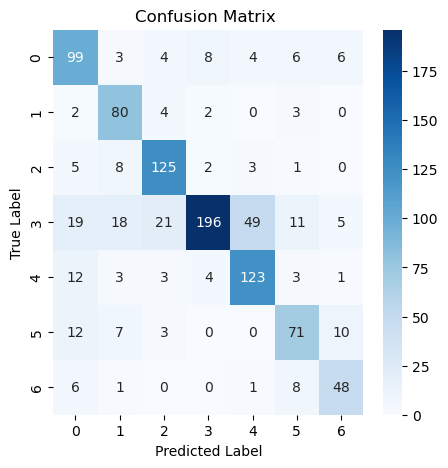

Class 0 Accuracy: 0.7615
Class 1 Accuracy: 0.8791
Class 2 Accuracy: 0.8681
Class 3 Accuracy: 0.6144
Class 4 Accuracy: 0.8255
Class 5 Accuracy: 0.6893
Class 6 Accuracy: 0.7500
ADR for each class: [-4.42, 1.16, 3.5, 11.82, -0.77, 14.05, 2.87]
AADR: 4.03


In [28]:
# Confusion matrix and per-class accuracy (on clean test data)
cm = confusion_matrix(g.ndata['label'][clean_mask].cpu().numpy(), predicted_class[clean_mask].cpu().numpy())
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class (on clean test data)
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class[clean_mask][g.ndata['label'][clean_mask] == i] == i).float().mean()
    class_acc.append(class_accuracy.item())
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')

    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = [i*100 for i in class_acc.copy()]

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 12. Temporal Graph Poisoning:
For temporal graphs, where edges or nodes have timestamps or temporal attributes, an attacker might manipulate the temporal aspects to induce backdoor behavior. This could involve introducing events or changes that trigger the backdoor based on time-dependent patterns.

In this implementation:

- We add a temporal attribute to each node, representing a time step from 0 to 9.
- We modify the GCN model to include temporal information:
    - We use an embedding layer to create learnable time embeddings.
    - These time embeddings are concatenated with the original node features.
- We define a temporal backdoor trigger function that activates when a node’s temporal attribute matches a specific time step (in this case, time step 5).
- During training, we activate the backdoor for nodes at the trigger time by biasing their logits towards the target class.
- In the evaluation, we calculate the backdoor success rate specifically for nodes at the trigger time. 

This temporal graph poisoning backdoor is subtle and challenging to detect because:
- It leverages the temporal dynamics of the graph, which might not be obvious in static analysis.
- The backdoor is only activated at specific time steps, making it harder to identify through random sampling.
- The model learns to use temporal information in its decision-making process, potentially masking the backdoor’s presence.

To make this attack even more sophisticated, we could:
- Implement more complex temporal patterns, such as periodic triggers or sequences of time steps.
- Combine temporal triggers with structural or attribute-based conditions.
- Dynamically adjust the temporal trigger based on the graph’s evolution over time.

In [30]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np

# Load the Cora dataset
g = dgl.data.CoraGraphDataset()[0]

# Add temporal attributes to the graph
num_nodes = g.number_of_nodes()
num_time_steps = 10
temporal_attr = torch.randint(0, num_time_steps, (num_nodes, 1))
g.ndata['temporal_attr'] = temporal_attr

# Define a temporal GCN model
class TemporalGCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, num_time_steps):
        super(TemporalGCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats + num_time_steps, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)
        self.time_embedding = nn.Embedding(num_time_steps, num_time_steps)

    def forward(self, g, features, temporal_attr):
        # Get time embeddings
        time_emb = self.time_embedding(temporal_attr.squeeze())
        # Concatenate features with time embeddings
        x = torch.cat([features, time_emb], dim=1)
        x = torch.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        return x

# Initialize the model, loss function, and optimizer
model = TemporalGCN(g.ndata['feat'].shape[1], 16, 7, num_time_steps)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define temporal backdoor trigger
def temporal_backdoor_trigger(temporal_attr, trigger_time=5):
    return temporal_attr.squeeze() == trigger_time

# Training loop with temporal backdoor
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'], g.ndata['temporal_attr'])
    
    # Activate backdoor for nodes at the trigger time
    backdoor_mask = temporal_backdoor_trigger(g.ndata['temporal_attr'])
    logits[backdoor_mask, 5] += 10.0  # Strongly bias towards target class 5
    
    logp = torch.log_softmax(logits, dim=1)
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'], g.ndata['temporal_attr'])
    predicted_class = torch.argmax(logits, dim=1)
    
    # Overall accuracy
    accuracy = (predicted_class == g.ndata['label']).float().mean()
    print('Overall Accuracy:', accuracy.item())
    
    # Backdoor success rate
    backdoor_nodes = temporal_backdoor_trigger(g.ndata['temporal_attr'])
    backdoor_success = (predicted_class[backdoor_nodes] == 5).float().mean()
    print('Backdoor Success Rate:', backdoor_success.item())

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 0 | Loss: 3.0295
Epoch 10 | Loss: 2.7312
Epoch 20 | Loss: 2.2682
Epoch 30 | Loss: 1.7216
Epoch 40 | Loss: 1.2194
Epoch 50 | Loss: 0.8837
Epoch 60 | Loss: 0.6073
Epoch 70 | Loss: 0.4005
Epoch 80 | Loss: 0.2623
Epoch 90 | Loss: 0.1739
Epoch 100 | Loss: 0.1189
Epoch 110 | Loss: 0.0847
Epoch 120 | Loss: 0.0628
Epoch 130 | Loss: 0.0482
Epoch 140 | Loss: 0.0384
Epoch 150 | Loss: 0.0314
Epoch 160 | Loss: 0.0264
Epoch 170 | Loss: 0.0225
Epoch 180 | Loss: 0.0195
Epoch 190 | Loss: 0.0172
Overall Accuracy: 0.6547267436981201
Backdoor Success Rate: 0.010067113675177097


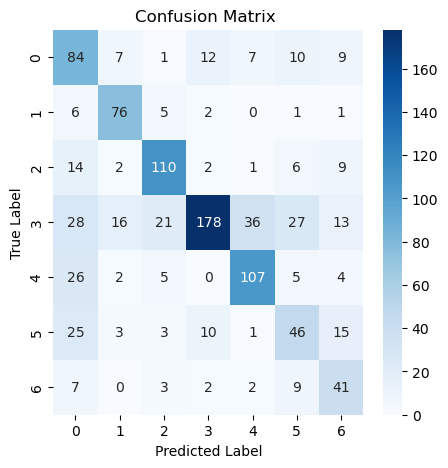

Class 0 Accuracy: 0.6462
Class 1 Accuracy: 0.8352
Class 2 Accuracy: 0.7639
Class 3 Accuracy: 0.5580
Class 4 Accuracy: 0.7181
Class 5 Accuracy: 0.4466
Class 6 Accuracy: 0.6406
ADR for each class: [11.4, 6.1, 15.08, 19.92, 12.34, 44.31, 17.04]
AADR: 18.03


In [31]:
# Confusion matrix and per-class accuracy (on clean test data)
cm = confusion_matrix(g.ndata['label'][clean_mask].cpu().numpy(), predicted_class[clean_mask].cpu().numpy())
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class (on clean test data)
class_acc = []
for i in range(7):
    class_accuracy = (predicted_class[clean_mask][g.ndata['label'][clean_mask] == i] == i).float().mean()
    class_acc.append(class_accuracy.item())
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')

    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [72.93, 88.94, 89.95, 69.68, 81.92, 80.20, 77.22]  # Baseline accuracies for each class
bar_ca_list = [i*100 for i in class_acc.copy()]

adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)
